# Loons Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [4]:
lkupclientid = 20 # loons

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              8121 non-null   int64  
 1   dimCustomerMasterId       8121 non-null   int64  
 2   customerNumber            8121 non-null   object 
 3   year                      8121 non-null   object 
 4   productGrouping           8121 non-null   object 
 5   totalSpent                8121 non-null   float64
 6   recentDate                8121 non-null   object 
 7   attendancePercent         8121 non-null   float64
 8   renewedBeforeDays         8121 non-null   int64  
 9   isBuyer                   8121 non-null   object 
 10  source_tenure             8121 non-null   int64  
 11  tenure                    8121 non-null   int64  
 12  distToVenue               8121 non-null   float64
 13  totalGames                8121 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [5]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          8121 non-null   int64  
 1   dimCustomerMasterId   8121 non-null   int64  
 2   customerNumber        8121 non-null   object 
 3   year                  8121 non-null   object 
 4   productGrouping       8121 non-null   object 
 5   totalSpent            8121 non-null   float64
 6   recentDate            8121 non-null   object 
 7   attendancePercent     8121 non-null   float64
 8   renewedBeforeDays     8121 non-null   int64  
 9   isBuyer               8121 non-null   object 
 10  source_tenure         8121 non-null   int64  
 11  tenure                8121 non-null   int64  
 12  distToVenue           8121 non-null   float64
 13  totalGames            8121 non-null   int64  
 14  recency               8121 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [6]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (7309, 47)
Unseen Data For Predictions: (812, 47)
Data for Modeling (A Class): (7309, 47)
Unseen Data For Predictions: (812, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [7]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(8121, 18)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [8]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  8121 non-null   int64  
 1   attendancePercent    8121 non-null   float64
 2   renewedBeforeDays    8121 non-null   int64  
 3   tenure               8121 non-null   int64  
 4   totalGames           8121 non-null   int64  
 5   missed_games_1       8121 non-null   int64  
 6   missed_games_2       8121 non-null   int64  
 7   missed_games_over_2  8121 non-null   int64  
 8   isNextYear_Buyer     8121 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 571.1 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,attendancePercent,renewedBeforeDays,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.14,-0.04,0.28,0.10,0.02,0.02,-0.03,0.13
attendancePercent,0.14,1.00,-0.09,0.03,-0.01,-0.12,-0.22,-0.47,0.12
renewedBeforeDays,-0.04,-0.09,1.00,0.09,-0.19,-0.11,-0.12,-0.11,-0.17
tenure,0.28,0.03,0.09,1.00,0.07,-0.00,-0.02,-0.02,-0.19
totalGames,0.10,-0.01,-0.19,0.07,1.00,0.63,0.52,0.56,0.09
missed_games_1,0.02,-0.12,-0.11,-0.00,0.63,1.00,0.48,0.37,0.06
missed_games_2,0.02,-0.22,-0.12,-0.02,0.52,0.48,1.00,0.47,0.06
missed_games_over_2,-0.03,-0.47,-0.11,-0.02,0.56,0.37,0.47,1.00,0.06
isNextYear_Buyer,0.13,0.12,-0.17,-0.19,0.09,0.06,0.06,0.06,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (6497, 9)
Unseen Data For Predictions: (1624, 9)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,8185
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(6497, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(None,
       dimCustomerMasterId  attendancePercent  renewedBeforeDays  tenure  \
 0             355960384.0           1.000000               14.0  4456.0   
 1             320346336.0           1.000000             -119.0    98.0   
 2             320340448.0           0.000000              -68.0  1792.0   
 3             320348896.0           0.750000                0.0  2232.0   
 4             356112736.0           0.857143               71.0  1621.0   
 ...                   ...                ...                ...     ...   
 6492          356145952.0           0.857143             -122.0  1150.0   
 6493          320341568.0           1.041667              -94.0   917.0   
 6494          356155872.0           0.833333               19.0  1914.0   
 6495          351996320.0           0.641026             -112.0   886.0   
 6496          385697664.0           1.000000               14.0  5318.0   
 
       totalGames  missed_games_1  missed_games_2  missed_games_over_2  
 0    

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.7766,0.8456,0.8674,0.7878,0.8256,0.5168,0.5218,0.0380
8,NGBClassifier,0.7695,0.8395,0.8898,0.7688,0.8248,0.4931,0.5049,1.6470
2,Gradient Boosting Classifier,0.7687,0.8401,0.8788,0.7732,0.8224,0.4945,0.5034,0.1190
9,Extreme Gradient Boosting,0.7660,0.8379,0.8488,0.7852,0.8156,0.4968,0.5000,0.3860
7,Random Forest Classifier,0.7637,0.8326,0.8545,0.7795,0.8151,0.4896,0.4940,0.2490
3,Extra Trees Classifier,0.7562,0.8149,0.8504,0.7729,0.8096,0.4728,0.4774,0.2250
0,Ada Boost Classifier,0.7549,0.8222,0.8422,0.7753,0.8072,0.4722,0.4758,0.0520
1,Decision Tree Classifier,0.7052,0.6887,0.7639,0.7557,0.7595,0.3786,0.3791,0.0100
4,K Neighbors Classifier,0.6787,0.7047,0.7819,0.7167,0.7478,0.3073,0.3098,0.0510
6,Logistic Regression,0.6096,0.5701,1.0000,0.6096,0.7574,0.0000,0.0000,0.0070


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7712,0.8421,0.8423,0.7946,0.8178,0.5110,0.5125
1,0.8135,0.8774,0.8959,0.8161,0.8541,0.5970,0.6020
2,0.7692,0.8289,0.8486,0.7889,0.8176,0.5046,0.5071
3,0.7923,0.8542,0.8896,0.7944,0.8393,0.5484,0.5555
4,0.7750,0.8543,0.8580,0.7907,0.8230,0.5157,0.5189
5,0.7769,0.8326,0.8801,0.7815,0.8279,0.5141,0.5215
6,0.7635,0.8443,0.8770,0.7680,0.8189,0.4824,0.4913
7,0.7881,0.8605,0.8639,0.8029,0.8323,0.5454,0.5481
8,0.7726,0.8271,0.8734,0.7797,0.8239,0.5061,0.5126
9,0.7437,0.8347,0.8454,0.7614,0.8012,0.4435,0.4484


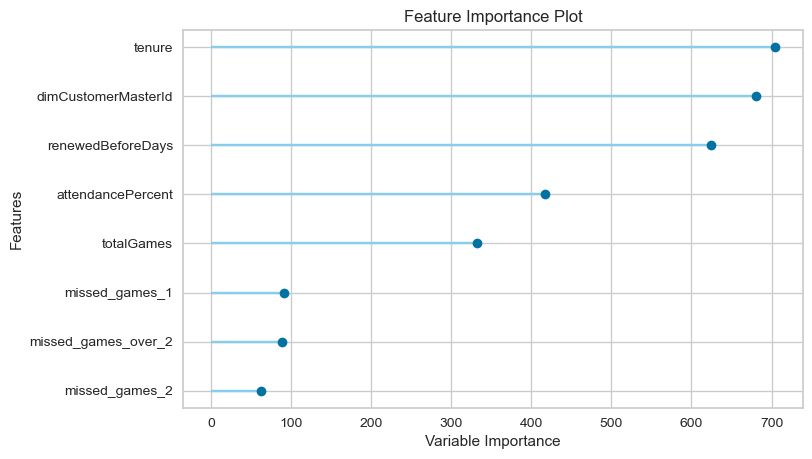

In [14]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?